In [2]:
import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt

# --- Ruta del CSV de alertas (ajústala si cambió) ---
ALERTS_CSV = "data/high_alerts_enriched_with_tx.csv"

# --- Carga ---
al = pd.read_csv(ALERTS_CSV, encoding="utf-8-sig")

# Normaliza columnas utilizadas
def _norm_col(c): 
    c = str(c).replace("\ufeff","").strip()
    c = re.sub(r'^[\'"]|[\'"]$', "", c)
    c = re.sub(r';+$', "", c)
    c = re.sub(r'\s+', '_', c)
    return c
al.columns = [_norm_col(c) for c in al.columns]

# Campos mínimos
req = {"rule_code","customer_sub_type"}
missing = [c for c in req if c not in al.columns]
if missing:
    raise RuntimeError(f"Faltan columnas en {ALERTS_CSV}: {missing}")

# Limpia rule_code y segmento
al["rule_code"] = al["rule_code"].astype(str).str.strip().str.upper()
al["customer_sub_type"] = (
    al["customer_sub_type"]
    .astype(str)
    .str.replace(r";+$", "", regex=True)  # limpia ';' final si viene
    .str.strip()
    .replace({"": np.nan, "NA": np.nan, "N/A": np.nan})
)

# (Opcional) filtra a Retail / IV / etc. Si quieres solo Retail:
# al = al[al["customer_sub_type"].str.contains("Retail", na=False)]
len(al), al["customer_sub_type"].nunique()


(2147, 9)

In [4]:
# --- Mapeo de reglas → áreas (ajusta/añade reglas si ves "Otros/No mapeado") ---
RULE_AREA = {
    # Monto
    "HASUMI": ("Monto","Inbound"),
    "P-HSUMI": ("Monto","Inbound"),
    "IN>AVG": ("Monto","Inbound"),
    "P-TLI": ("Monto","Inbound"),
    "PGAV-IN": ("Monto","Inbound"),

    "HASUMO": ("Monto","Outbound"),
    "P-HSUMO": ("Monto","Outbound"),
    "OUT>AVG": ("Monto","Outbound"),
    "P-TLO": ("Monto","Outbound"),
    "PGAV-OUT": ("Monto","Outbound"),

    "P-LVAL": ("Monto","N/A"),
    "P-LBAL": ("Monto","N/A"),

    # Frecuencia
    "HANUMI": ("Frecuencia","Inbound"),
    "HNR-IN": ("Frecuencia","Inbound"),
    "RVT-IN": ("Frecuencia","Inbound"),
    "P-HVI": ("Frecuencia","Inbound"),

    "HANUMO": ("Frecuencia","Outbound"),
    "HNR-OUT": ("Frecuencia","Outbound"),
    "RVT-OUT": ("Frecuencia","Outbound"),
    "P-HVO": ("Frecuencia","Outbound"),

    # Contraparte / País / Moneda / Banco
    "OCMC_1": ("Contraparte",None),
    "MCOC_1": ("Contraparte",None),
    "NCOU":   ("Contraparte",None),
    "HRCOU":  ("Contraparte",None),
    "PRCOU":  ("Contraparte",None),
    "NBCOU":  ("Contraparte",None),
    "SUMCCO": ("Contraparte",None),
    "SUMCCI": ("Contraparte",None),
    "NUMCCO": ("Contraparte",None),
    "NUMCCI": ("Contraparte",None),
    "NCU":    ("Contraparte",None),

    # Comportamiento transaccional
    "OUT>%IN":  ("Comportamiento","N/A"),
    "IN>%OUT":  ("Comportamiento","N/A"),
    "IN-OUT-1": ("Comportamiento","N/A"),
    "SEC":      ("Comportamiento","N/A"),

    # Descriptivos / Perfil / Cambios
    "P-1ST":   ("Descriptivos",None),
    "P-2ND":   ("Descriptivos",None),
    "VC":      ("Descriptivos",None),
    "DORMANT": ("Descriptivos",None),
    "CDC01":   ("Descriptivos",None),
    "CDC02":   ("Descriptivos",None),
    "CDC03":   ("Descriptivos",None),
}

def map_area_tuple(rule_code: str):
    if pd.isna(rule_code):
        return ("Otros/No mapeado", None)
    t = RULE_AREA.get(str(rule_code).upper().strip())
    return t if t is not None else ("Otros/No mapeado", None)

# ⚠️ Aquí está el cambio clave: apply(...) y luego expandimos en 2 columnas
al[["area_main","area_sub"]] = al["rule_code"].apply(map_area_tuple).apply(pd.Series)

# Combo útil para desgloses finos (por ejemplo "Monto — Inbound")
al["area_combo"] = np.where(
    al["area_sub"].notna(),
    al["area_main"] + " — " + al["area_sub"],
    al["area_main"]
)

# Chequeo rápido de reglas no mapeadas (para que las agregues si hace falta)
unmapped = (
    al.loc[al["area_main"]=="Otros/No mapeado","rule_code"]
      .value_counts()
      .head(30)
)
if len(unmapped):
    print("Reglas no mapeadas (top 30):")
    display(unmapped)
else:
    print("Todas las reglas quedaron mapeadas ✅")


Reglas no mapeadas (top 30):


rule_code
AAD-SMUR    31
AAD-RS       2
AAD-IO       2
AAD-LA       1
AAD-RD       1
Name: count, dtype: int64

In [9]:
def segment_pie(df_seg, seg_name, min_alerts_for_pie=10):
    g = (df_seg.groupby("area_main", dropna=False)
                 .agg(alerts=("rule_code","count"))
                 .assign(pct=lambda d: 100*d["alerts"]/d["alerts"].sum())
                 .sort_values("alerts", ascending=False))
    tot = int(g["alerts"].sum())

    # Texto resumen
    print(f"\n=== {seg_name} ===")
    print(f"Alertas totales: {tot:,}")
    display(g.style.format({"alerts":"{:,.0f}","pct":"{:,.1f}"}))

    # Pie chart si hay suficiente muestra
    if tot >= min_alerts_for_pie:
        fig, ax = plt.subplots(figsize=(5,5))
        ax.pie(g["alerts"], labels=g.index, autopct="%1.1f%%", startangle=90)
        ax.set_title(f"{seg_name} — mix de áreas (%)")
        ax.axis("equal")
        plt.show()
    else:
        print("(Muy pocas alertas para gráfico de torta)")

def build_summary_table(df):
    # tabla multi-segmento: filas=segmento, cols=área (counts y %)
    ct = (pd.crosstab(df["customer_sub_type"], df["area_main"])
            .sort_index())
    ct["total_alerts"] = ct.sum(axis=1)
    pct = ct.div(ct["total_alerts"], axis=0).mul(100).round(1).add_suffix("_pct")
    summary = pd.concat([ct, pct], axis=1).sort_values("total_alerts", ascending=False)
    return summary



=== Big Companies ===
Alertas totales: 13


,alerts,pct
area_main,,
Comportamiento,5,38.5
Monto,4,30.8
Otros/No mapeado,2,15.4
Frecuencia,1,7.7
Descriptivos,1,7.7


(Muy pocas alertas para gráfico de torta)

=== Imports/Exports ===
Alertas totales: 142


,alerts,pct
area_main,,
Monto,82,57.7
Comportamiento,35,24.6
Otros/No mapeado,16,11.3
Frecuencia,8,5.6
Descriptivos,1,0.7


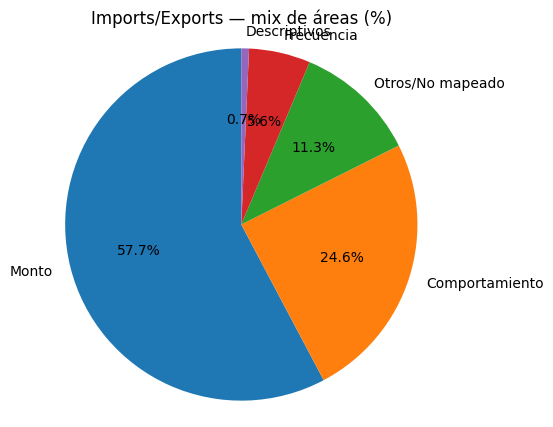


=== Institutional Clients ===
Alertas totales: 18


,alerts,pct
area_main,,
Descriptivos,9,50.0
Contraparte,4,22.2
Otros/No mapeado,4,22.2
Frecuencia,1,5.6


(Muy pocas alertas para gráfico de torta)

=== Investment Vehicle ===
Alertas totales: 181


,alerts,pct
area_main,,
Monto,103,56.9
Comportamiento,29,16.0
Frecuencia,26,14.4
Contraparte,14,7.7
Otros/No mapeado,6,3.3
Descriptivos,3,1.7


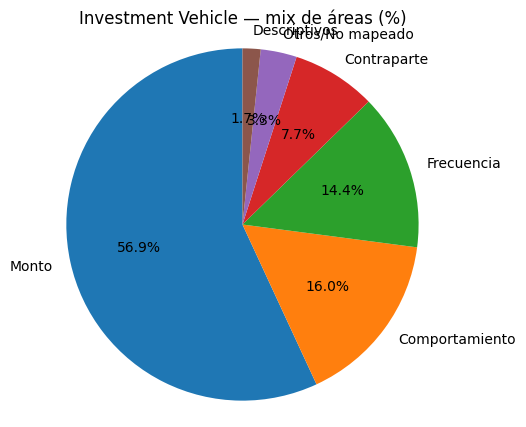


=== LV Related- Organization ===
Alertas totales: 82


,alerts,pct
area_main,,
Monto,57,69.5
Comportamiento,15,18.3
Contraparte,6,7.3
Frecuencia,3,3.7
Descriptivos,1,1.2


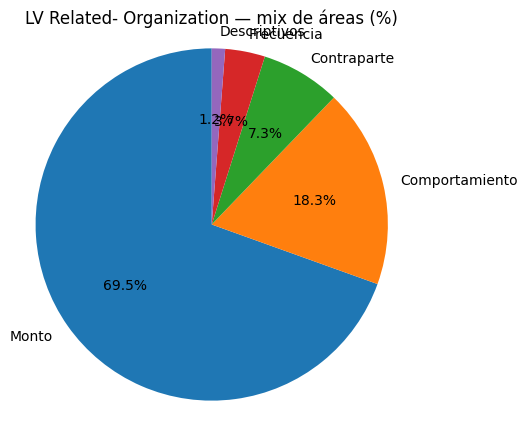


=== Non-Profit ===
Alertas totales: 3


,alerts,pct
area_main,,
Contraparte,3,100.0


(Muy pocas alertas para gráfico de torta)

=== Retail ===
Alertas totales: 1,023


,alerts,pct
area_main,,
Monto,662,64.7
Frecuencia,166,16.2
Comportamiento,107,10.5
Contraparte,67,6.5
Descriptivos,14,1.4
Otros/No mapeado,7,0.7


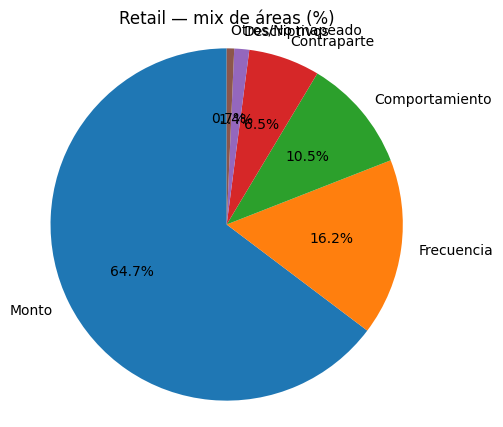


=== Retail, Imports/Exports ===
Alertas totales: 1


,alerts,pct
area_main,,
Otros/No mapeado,1,100.0


(Muy pocas alertas para gráfico de torta)

=== SIN_SEGMENTO ===
Alertas totales: 684


,alerts,pct
area_main,,
Monto,262,38.3
Frecuencia,219,32.0
Comportamiento,133,19.4
Descriptivos,51,7.5
Contraparte,18,2.6
Otros/No mapeado,1,0.1


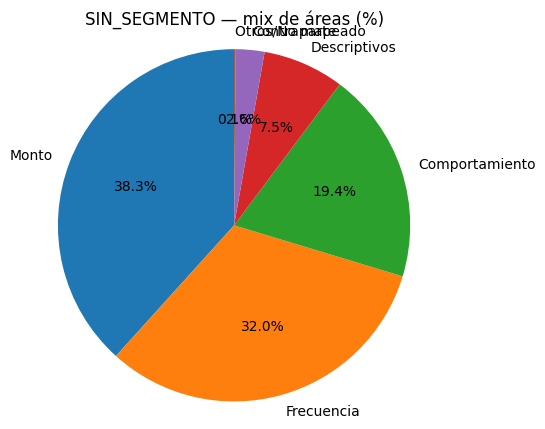

area_main,Comportamiento,Contraparte,Descriptivos,Frecuencia,Monto,Otros/No mapeado,total_alerts,Comportamiento_pct,Contraparte_pct,Descriptivos_pct,Frecuencia_pct,Monto_pct,Otros/No mapeado_pct,total_alerts_pct
customer_sub_type,,,,,,,,,,,,,,
Retail,107,67,14,166,662,7,"1,023",10,6,1,16,65,1,100
SIN_SEGMENTO,133,18,51,219,262,1,684,19,3,8,32,38,0,100
Investment Vehicle,29,14,3,26,103,6,181,16,8,2,14,57,3,100
Imports/Exports,35,0,1,8,82,16,142,25,0,1,6,58,11,100
LV Related- Organization,15,6,1,3,57,0,82,18,7,1,4,70,0,100
Institutional Clients,0,4,9,1,0,4,18,0,22,50,6,0,22,100
Big Companies,5,0,1,1,4,2,13,38,0,8,8,31,15,100
Non-Profit,0,3,0,0,0,0,3,0,100,0,0,0,0,100
"Retail, Imports/Exports",0,0,0,0,0,1,1,0,0,0,0,0,100,100


area_main,Monto,Frecuencia,total_alerts,monto_freq,monto_freq_pct
customer_sub_type,,,,,
Retail,662,166,1023,828,80.9
LV Related- Organization,57,3,82,60,73.2
Investment Vehicle,103,26,181,129,71.3
SIN_SEGMENTO,262,219,684,481,70.3
Imports/Exports,82,8,142,90,63.4
Big Companies,4,1,13,5,38.5
Institutional Clients,0,1,18,1,5.6
Non-Profit,0,0,3,0,0.0
"Retail, Imports/Exports",0,0,1,0,0.0


In [10]:
# Segmentos presentes en los datos
segments = (al["customer_sub_type"].dropna().unique().tolist())
segments = sorted(segments, key=lambda s: (s is None, s))  # orden alfabético

# 1) Resumen por segmento con pie charts
for seg in segments:
    df_seg = al[al["customer_sub_type"] == seg]
    segment_pie(df_seg, seg_name=seg, min_alerts_for_pie=20)

# 2) Tabla comparativa multi-segmento
summary = build_summary_table(al)
display(summary.style.format("{:,.0f}")
        .set_caption("Alertas por área y segmento — volúmenes y %"))

# 3) (Opcional) extracto para “Monto + Frecuencia” como driver
summary_driver = (
    summary[["Monto","Frecuencia","total_alerts"]]
    .assign(monto_freq=lambda d: d["Monto"]+d["Frecuencia"],
            monto_freq_pct=lambda d: 100*d["monto_freq"]/d["total_alerts"])
    .sort_values("monto_freq_pct", ascending=False)
)
display(summary_driver.style.format({"monto_freq":"{:,.0f}","monto_freq_pct":"{:,.1f}"}))
